# 0.0 IMPORTS

In [1]:
import random
import warnings
import sweetviz
import pandas      as pd
import numpy       as np
import seaborn     as sns

import matplotlib.pyplot as plt
from sklearn.metrics         import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn                import combine as c
from imblearn                import under_sampling as us
from imblearn                import over_sampling as oversamp
from scipy                   import stats as ss
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing as pp
from sklearn                 import metrics       as m
from keras                   import models as ml
from keras                   import layers as l
#from pandas_profiling        import ProfileReport
from IPython.core.display    import HTML

warnings.filterwarnings( 'ignore' )

In [2]:
import sweetviz as sv

## 0.1 Helper Functions

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/train_users.csv', low_memory=True) 

df_sessions = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/sessions.csv', low_memory=True)


# 1.0 Passo 01 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()
df1_sessions = df_sessions.copy()

## 1.1 Data Dimensions

In [6]:
print(f'Número de linhas é igual a: {df1.shape[0]}')
print(f'Número de colunas é igual a: {df1.shape[1]}')

Número de linhas é igual a: 213451
Número de colunas é igual a: 16


In [7]:
#Sessions
print(f'Número de linhas é igual a: {df1_sessions.shape[0]}')
print(f'Número de colunas é igual a: {df1_sessions.shape[1]}')

Número de linhas é igual a: 10567737
Número de colunas é igual a: 6


## 1.2 Data Types

In [8]:
#Data types df1
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
#Data types df1_sessions
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [10]:
df1.isna().sum() /len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df1_sessions.isna().sum()/len(df1_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [12]:
df1['first_affiliate_tracked'].drop_duplicates()
#aux = df1[df1[ 'age'].isna()]
#aux['country_destination'].value_counts(normalize=True)

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [13]:
#Remover NAs
# =====================USERS======================================

#date_first_booking
date_first_booking_max =  pd.to_datetime( df1['date_first_booking']).max().strftime('%Y%m%d')

df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max)


#age: Preencher como valor médio
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna( avg_age).astype(int)

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]


#============================================SESSIONS=========================================
#user_id        3%
df1_sessions = df1_sessions[~df1_sessions['user_id'].isna()]

#action         0.7%
df1_sessions = df1_sessions[~df1_sessions['action'].isna()]

#action_type    11%
df1_sessions = df1_sessions[~df1_sessions['action_type'].isna()]

#action_detail  11%
df1_sessions = df1_sessions[~df1_sessions['action_detail'].isna()]

#secs_elapsed   1.2%
df1_sessions = df1_sessions[~df1_sessions['secs_elapsed'].isna()]

In [14]:
df1.isna().sum() / len( df1 )

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [15]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4 Change Data Types

In [16]:
df1.dtypes

id                         object
date_account_created       object
timestamp_first_active      int64
date_first_booking         object
gender                     object
age                         int32
signup_method              object
signup_flow                 int64
language                   object
affiliate_channel          object
affiliate_provider         object
first_affiliate_tracked    object
signup_app                 object
first_device_type          object
first_browser              object
country_destination        object
dtype: object

In [17]:
#date_account_created   
df1['date_account_created']=pd.to_datetime( df1['date_account_created'])
#timestamp_first_active  
df1['timestamp_first_active']=pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking']=pd.to_datetime( df1['date_first_booking'])
#age                      
df1['age']= df1['age'].astype('int64')


## 1.5 Check Balanced Data

In [18]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive Analyses

In [19]:
#==================Users===================================
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes( include= ['datetime64[ns]'])


#====================Sessions==========================================
num_attributes_sessions  = df1_sessions.select_dtypes( include=['int64', 'float64'])
cat_attributes_sessions  = df1_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df1_sessions.select_dtypes( include= ['datetime64[ns]'])

### 1.6.1 Numerical -Users

In [20]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.1 Numerical -Sessions

In [21]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes_sessions.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame( num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame( num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.2 Numerical - Users

In [22]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.3 Categorical -Sessions

In [23]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [24]:
#lista de atributos para cramer v
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for i in range( len(cat_attributes_list) ):
    corr_list = []
    
    for j in range (len(cat_attributes_list ) ):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        #Correlação
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat] )
        
        #append a list
        corr_list.append( corr )
    # append correlation para cada ref atrtibuts
    corr_dict[ref] = corr_list

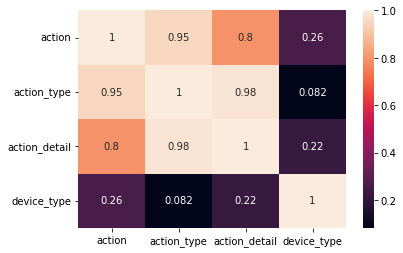

In [25]:
d = pd.DataFrame( corr_dict)
d = d.set_index(d.columns)
sns.heatmap( d, annot=True);

# 2.0 PASSO 02 - Feature Engeneering


In [26]:
df2 =df1.copy()

df2.shape


(122636, 16)

In [27]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Create new Features

In [28]:
# days from first activate up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime("%Y-%m-%d") )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] -df2['first_active']).apply( lambda x: x.days)

#days from first activate up to account create
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] -df2['first_active']).apply( lambda x: x.days)

#days from account create up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] -df2['date_account_created']).apply( lambda x: x.days)
    

#===================================First activate======================================
#Year first active
df2['year_first_active'] = df2['first_active'].dt.year

#Month first active
df2['month_first_active'] = df2['first_active'].dt.month


#Day first active
df2['day_first_active'] = df2['first_active'].dt.day


#Day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek


#Week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#===================================Booking======================================
#Year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#Month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#Day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#Day of Week of first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#Week of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear


#===================================First account created======================================
#Year first active
df2['year_account_created'] = df2['date_account_created'].dt.year

#Month first active
df2['month_account_created'] = df2['date_account_created'].dt.month


#Day first active
df2['day_account_created'] = df2['date_account_created'].dt.day


#Day of week first active
df2['day_of _week_first_account_created'] = df2['date_account_created'].dt.dayofweek


#Week of year first active
df2['week_of _year_first_account_created'] = df2['date_account_created'].dt.weekofyear




In [29]:
df2.shape

(122636, 35)

# 3.0 PASSO 03 - Data Filtering


In [30]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [31]:
#Age:entre 15 e 120 pois há poucas pessoas como mais de 120 anos
df3 =  df3[( df2['age']> 15) & (df3['age'] < 120 )]

# secs_elapsed - Não há possibilidade de ter 0 elapsed
#df1_sessions = df1_sessions[ df1_sessions['secs_elapsed']> 0]

## 3.2 Columns Selection

In [32]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active'] # original datetime
df3 = df3.drop( cols, axis=1 )

# 4.0 - BALANCED DATASET

In [33]:
df4 = df3.copy()
df4.shape

(122636, 31)

In [34]:
#Encoder Categorical Variable
ohe = pp.OneHotEncoder()

#Numerical
col_num = df4.select_dtypes(include=['int64','float64']).columns.tolist()

#Categorical
col_cat = df4.select_dtypes(exclude=['int64','float64', 'datetime64[ns]']).drop(['id','country_destination'], axis=1).columns.tolist()


#Encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[col_cat]).toarray(), index=df4.index)


# Joing Numerical and Categorical
df42 = pd.concat( [ df4[col_num], df4_dummy], axis=1)



In [35]:
df42.dtypes

age                                                int64
signup_flow                                        int64
days_from_first_active_until_booking               int64
days_from_first_active_until_account_created       int64
days_from_account_created_until_first_booking      int64
                                                  ...   
113                                              float64
114                                              float64
115                                              float64
116                                              float64
117                                              float64
Length: 138, dtype: object

## 4.1 Random Undersampling

In [37]:
# Ratio_balanced
ratio_balanced = {'NDF': 10000}

#Para fazer reamostragem : definir um sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

#aplicar o sampler
X_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

In [38]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [39]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2 Random Oversampling

In [40]:
# Ratio_balanced
#ratio_balanced = {'NDF': 10000}

#Para fazer reamostragem : definir um sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='minority', random_state=32)

#aplicar o sampler
X_over, y_over = oversampling.fit_resample(df42, df4['country_destination']) 

In [41]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [42]:
y_over.value_counts()

NDF      54852
PT       54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
Name: country_destination, dtype: int64

## 4.3 Smote + Tomeklink

In [43]:
len(df4['country_destination'])

122636

In [44]:
40000/7511

5.325522566901877

In [45]:
#df4['country_destination'].value_counts().to_dict()
ratio_balanced = {'NDF':   54852,
                  'US':    48057,
                  'other': 6*7511,
                  'FR':    12*3669,
                  'IT':    20*2014,
                  'GB':    30*1758,
                  'ES':    30*1685,
                  'CA':    40*1064,
                  'DE':    50*841,
                  'NL':    80*595,
                  'AU':    95*433,
                  'PT':    300*157}

In [ ]:
#define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

In [ ]:
#Numerical data
df43 = X_smt[col_num]

#Categorical Data
df44 =X_smt.drop(col_num, axis=1)
df45 = pd.DataFrame( ohe.inverse_transform(df44), columns=col_cat, index=df44.index)
#Join Numerical categorical
df46 = pd.concat([df43, df45], axis=1)
df4['country_destination']=y_smt


In [ ]:
df46.head()

In [ ]:
df4['country_destination'].value_counts()

In [ ]:
y_smt.value_counts()

# 5.0 - EXPLORATORY DATA ANALYSIS (EDA)

## 5.1 Analise univariada - Dados balanceados


In [ ]:
df51 = df46.copy()

In [ ]:
df52 = df4.copy()

In [ ]:
df52.columns

In [ ]:
#my_report = sv.analyze(df51)
#my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

## 5.2 Analise Bivariada - Validação de hipoteses -  Dados  desbalanceados


**H01**. Em todos os destinos, os usuários levam 15 dias em média, para fazer a primeira reserva no airbnb, desde a primeira ativação

**Verdadeiro** em todo destinos os usuários levam em média  até 6 dias para fazer a primeira reserva

In [ ]:

aux01 = df52[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()


plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', data=aux01.sort_values('days_from_first_active_until_booking'))



#Remove outliers
plt.figure(figsize=(20,12))
plt.subplot(2, 1, 2)
aux02 = df52[ df52['country_destination'] != 'NDF' ]
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
            data=aux02.sort_values('days_from_first_active_until_booking'));




**H02**. Em todos os destinos, os usuários levam 3 dias em média, para fazer o cadastro no site

**Verdadeiro** Em todos os destinos os usuario levam até 2 dias para ativar o cadastro

In [ ]:

aux01 = df52[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()


plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
            data=aux01.sort_values('days_from_first_active_until_account_created'))



**H03**. O Volume de reserva anual feitas durante  o verão aumentaram 20% para destinos dentro dos USA

**Falsa** Há um volume maior que 20% até 2013, depois elas caem.

In [ ]:
aux01 = df52[['year_first_booking', 'month_first_booking','country_destination']].\
    groupby(['year_first_booking', 'month_first_booking','country_destination' ]).\
    size().reset_index().rename(columns={0:'count'})

#Select only summer´s months( 6, 7, 8, 9)
aux01 = aux01[( aux01['month_first_booking'].isin( [6, 7, 8, 9] ) ) & (aux01['country_destination'] == 'US')]
              

aux02 = aux01[['year_first_booking', 'count']].groupby( 'year_first_booking' ).sum().reset_index()
aux02['delta'] = aux02['count'].pct_change()

plt.figure(figsize=(20,12))
sns.barplot(x='year_first_booking', y='delta', data=aux02)

**H04**. Os usuários do sexo feminino fazem 10% mais reservas fara fora dos USA

**H05**. O Canal de mkt do google representa 40% das reservas para fora dos USA

**H06**. Destino dentro dos USA, representa 20% em todos os canais

**H07**. A idade média das pessoas é de 35 anos em todos os destinos

**H08**. A porcentagem de usuarios que usam o site na lingua ingles_Americano para reservar acomodações em qualquer destino é maior que 40%

**H09**. O número de reservas do airbnb é crescente ou decrescente ao longo dos anos?

**H10**. O número de reservas do airbnb é crescente ao longo dos anos?

## 5.3  Validação de hipoteses -  Dados  desbalanceados


In [ ]:
## 5.2 Analise Bivariada - Validação de hipoteses -  Dados  desbalanceados


# <font color='red'> 5.0 - DATA PREPARATION</font>

In [ ]:
df5 = df4.copy()

In [ ]:
# Dummy Variable
df5_dummy = pd.get_dummies( df5.drop( ['id','country_destination'], axis=1 ) )

#Join ID and country_destiantion
df5 =pd.concat( [  df5[['id', 'country_destination']], df5_dummy],axis=1)

In [ ]:
df5.shape

# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()

In [ ]:
X = df6.drop(['id', 'country_destination'], axis=1)
y = df6['country_destination'].copy()

In [ ]:
#Split dataset
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 ) 

# 7.0 MACHINE LEARNING MODEL

In [ ]:
x_train = X_train
x_test = X_test

## 7.1 Baseline Model 

In [ ]:
#random.choices(populacao =, weght= , k=)
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().to_list()
k_num = y_test.shape[0]
country_destination_weghts = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

# Modelo aleatório
yhat_random = random.choices(population= country_destination_list, 
                             weights = country_destination_weghts,
                             k = k_num)


### 7.1.1 Baseline Model Performance

In [ ]:
#Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

#Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

#Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Balanced Accuracy: {kappa_random}')
print('\n')

#Classification Report
print(m.classification_report(y_test, yhat_random))

#Confusion Matrix
cm = confusion_matrix( y_test, yhat_random)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);


## 7.2 Neural Network - MLP

In [ ]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1 ) ).toarray()

In [ ]:
#df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

In [ ]:
# Model definition
model = ml.Sequential()
model.add(l.Dense( 256, input_dim=x_train.shape[1], activation='relu') )
model.add(l.Dense( 12, activation='softmax') )

#Model compile
model.compile( loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'] )

#training model
model.fit( x_train , y_train_nn, epochs=100 )

## 7.2.2 NN Performance

In [ ]:
#Predict
pred_nn = model.predict( x_test )

#invert prediction
yhat_nn = ohe.inverse_transform( pred_nn)

#Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn =  yhat_nn.reshape(1, -1 )[0]

In [ ]:
#Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

#Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

#Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')
print('\n')

#Classification Report
print(m.classification_report(y_test_nn, yhat_nn))

#Confusion Matrix
cm = confusion_matrix( y_test_nn, yhat_nn)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);



## 7.2.3 NN Performance - Cross Validation

In [ ]:
#Generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split(x_train, y_train):
    print(f'Fold number {i}/{num_folds}\n')
    #Get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
   
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    #target hot_encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape( -1, 1)).toarray()
    
    #Model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))
    
    #Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    
    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform( pred_nn)
    
    #prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1)[0]
    
    #metrics
    
    #Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn)
   
    #Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn)
    
    i += 1

In [ ]:
print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}\n')
      
print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')